# Coexpression of ISGs under stimulation

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [6]:
adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [7]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [8]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
adata.shape

(69958, 36588)

In [10]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [11]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

### Define ISG classes

In [12]:
isg_classes = pd.read_csv('../isg_classes.csv')

In [13]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0]

In [16]:
# cytokines = pd.read_csv('../mart_export.txt')['Gene name'].tolist()
# cytokines = v_df.query('cytokine').gene.tolist()

### Setup memento

In [17]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [18]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [19]:
memento.setup_memento(adata, q_column='q', trim_percent=0.05)

Version 0.0.6


In [77]:
mhc_1 = []
mhc_2 = []
for g in included_de_genes:
    if 'HLA' in g:
        if len(g.split('-')[1]) > 1:
            mhc_2.append(g)
        else:
            mhc_1.append(g)

### Heatmap for correlations at baseline

In [68]:
ct = 'C'
stim = adata[(adata.obs.stim=='gamma') & adata.obs.ct.isin([ct])].copy().copy()
stim.obs['group'] = 1
memento.create_groups(stim, label_columns=['group', 'ct'])
memento.compute_1d_moments(stim, min_perc_group=.9) 

In [69]:
included_de_genes = list(set(t1_isg+t2_isg+shared_isg) & set(stim.var.index))

In [70]:
memento.compute_2d_moments(stim, gene_pairs=list(itertools.combinations(included_de_genes,2)))
c_df = memento.get_2d_moments(stim, groupby='ct')

In [155]:
ct_c_df = c_df[['gene_1', 'gene_2', 'ct_C']]
ct_heatmap = pd.DataFrame(np.zeros((len(included_de_genes), len(included_de_genes))), columns=included_de_genes, index=included_de_genes)
for idx, row in ct_c_df.iterrows():
    
    ct_heatmap.loc[row['gene_1'], row['gene_2']] = row['ct_C']
    ct_heatmap.loc[row['gene_2'], row['gene_1']] = row['ct_C']

In [240]:
# Manual construction of linkage matrix
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster


row_linkage = hierarchy.linkage(distance.pdist(ct_heatmap), method='average')
cluster_assignments = fcluster(row_linkage, t=100, criterion='maxclust')
num_clusters = 20
top_clusters= dict(zip(pd.Series(cluster_assignments).value_counts().head(num_clusters).index, range(num_clusters)))
top_clusters_reverse= dict(zip(range(num_clusters), pd.Series(cluster_assignments).value_counts().head(num_clusters).index, ))

coarse_cluster_assignments = np.array([top_clusters[i] if i in top_clusters else -1 for i in cluster_assignments])

In [210]:
print(ct_heatmap.shape)
cg = sns.clustermap(ct_heatmap.fillna(0.0), center=0, vmax=0.3, metric='euclidean', row_linkage=row_linkage, col_linkage=row_linkage); plt.close()
row_inds = cg.dendrogram_row.reordered_ind
col_inds = cg.dendrogram_col.reordered_ind
print(ct_heatmap.shape)


(446, 446)
(446, 446)


In [211]:
def classify_color_isg(x):
    
    if x in shared_isg:
        return -1
    if x in t1_isg:
        return 0
    if x in t2_isg:
        return 1
    return 'impossible'

In [232]:
# For ISG type coloring
from matplotlib.colors import LinearSegmentedColormap


myColors = sns.color_palette('husl')[:3]
class_list = np.array([classify_color_isg(g) for g in included_de_genes])[np.newaxis, :]
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

myColors = sns.color_palette('Paired', num_clusters+1)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
class_list = coarse_cluster_assignments[np.newaxis, :]

In [233]:
myColors

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098)]

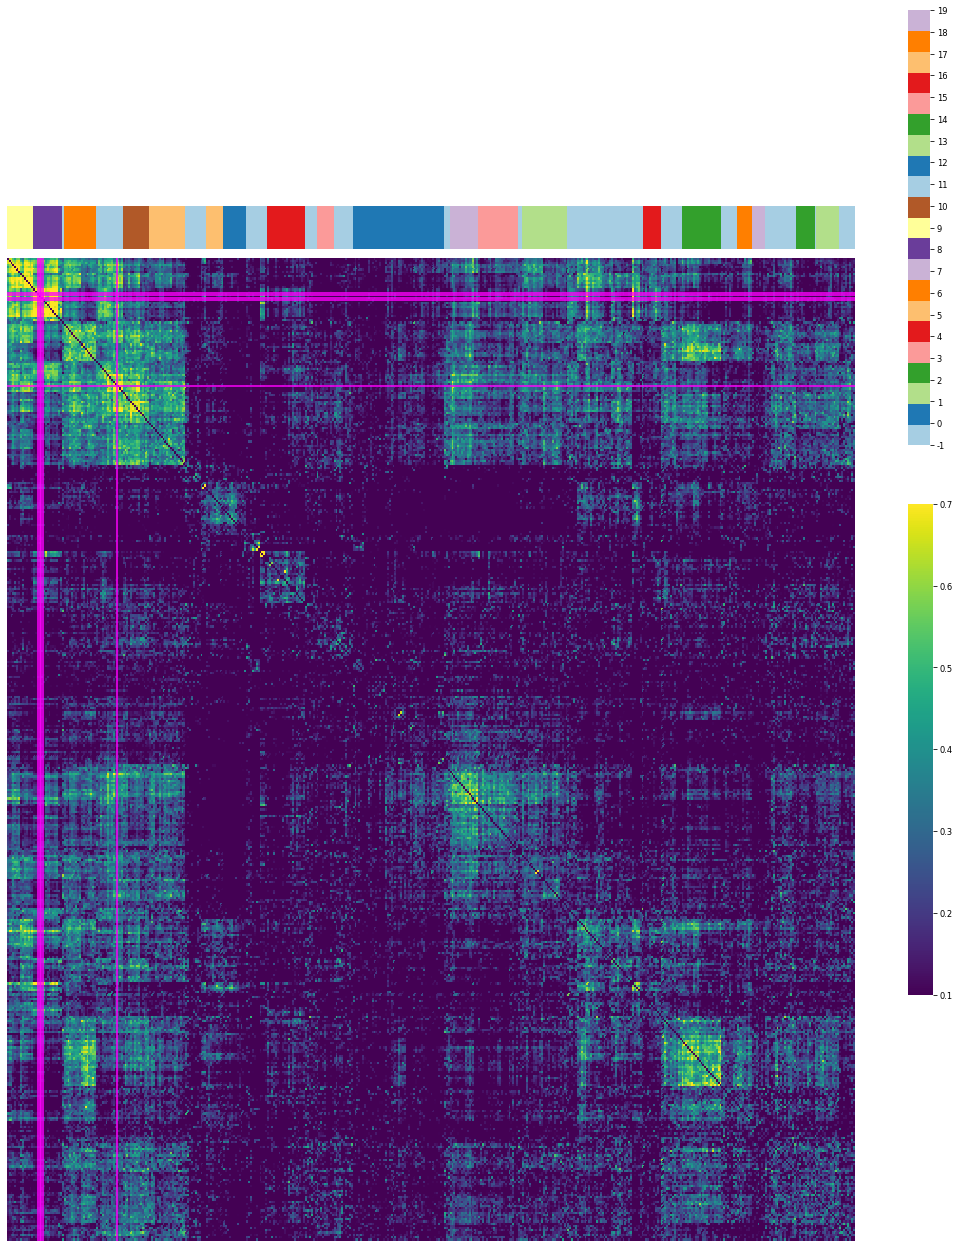

In [237]:
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((21,20), (1,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((21,20), (0,0), colspan=19, rowspan=1)

sns.heatmap(ct_heatmap.iloc[row_inds, col_inds], cmap='viridis', vmax=0.7, vmin=0.1, ax=ax1, yticklabels=False, xticklabels=False, cbar_kws={"shrink": 0.5})
sns.heatmap(class_list[:, row_inds], cmap=cmap, ax=ax2, yticklabels=False, xticklabels=False, cbar_kws={"shrink": 10})
colorbar = ax2.collections[0].colorbar
colorbar.set_ticks([-1] + list(range(num_clusters+1)))
colorbar.set_ticklabels([-1] + list(range(num_clusters+1)))

# colorbar.set_ticklabels(['shared', 'type1', 'type2'])

some_genes = list(set(mhc_1)&set(included_de_genes))
for g in some_genes:
    idx = np.where(np.array(row_inds)==ct_heatmap.index.get_loc(g))[0][0]
    ax1.plot([0, len(included_de_genes)], [idx, idx], color='magenta')
    ax1.plot([idx, idx],[0, len(included_de_genes)], color='magenta',)
    
selected_genes = {}
locations = [
 
]
colors = sns.color_palette('husl', len(locations))
i = 0

for x1, x2 in locations:
    
    ax1.plot([x1, x1],[0, len(included_de_genes)], color=colors[i],)
    ax1.plot([x2, x2],[0, len(included_de_genes)], color=colors[i])

    selected_genes[i]= ct_heatmap.index[np.array(row_inds)[x1:x2]]
    
    i+=1

### Pick out genes and run memento

In [245]:
isg_classes.query("gene == 'IFITM3'")

,gene,is_type1_6,is_type2_6,is_shared_6,overall_type
231,IFITM3,True,False,False,type1


In [243]:
ct_heatmap.index[cluster_assignments == top_clusters_reverse[9]]

Index(['PLAAT4', 'PSMB10', 'IFI30', 'PSMB9', 'BST2', 'IFITM3', 'NMI', 'PSMB8',
       'GSTK1', 'PSME2', 'PSME1', 'UBE2L6', 'IFITM1', 'GBP3'],
      dtype='object')

In [246]:
gene_sets = {}
for cluster in [9, 8, 6, 7, 14]:
    
    gene_sets[cluster] = ct_heatmap.index[cluster_assignments == top_clusters_reverse[cluster]].tolist()